In [1]:
import os
import struct
import numpy as np
import torch
from torch import nn
from torch import optim
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [2]:

__all__ = ["ColorMNIST"]


class ColorMNIST(Dataset):
    def __init__(self, color, split, path, transform_list=[], randomcolor=False):
        assert color in ['num', 'back', 'both'], "color must be either 'num', 'back' or 'both"
        self.pallette = [[255, 0, 0],
                         [255, 0, 0],
                         [255, 0, 0],
                         [0, 255, 0],
                         [0, 255, 0],
                         [0, 255, 0],
                         [0, 0, 255],
                         [0, 0, 255],
                         [220, 220, 80],
                         [220, 220, 80]]

        if split == 'train':
            fimages = os.path.join(path, 'raw', 'train-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 'train-labels-idx1-ubyte')
        else:
            fimages = os.path.join(path, 'raw', 't10k-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 't10k-labels-idx1-ubyte')

        # Load images
        with open(fimages, 'rb') as f:
            _, _, rows, cols = struct.unpack(">IIII", f.read(16))
            self.images = np.fromfile(f, dtype=np.uint8).reshape(-1, rows, cols)

        # Load labels
        with open(flabels, 'rb') as f:
            struct.unpack(">II", f.read(8))
            self.labels = np.fromfile(f, dtype=np.int8)
            self.labels = torch.from_numpy(self.labels.astype(np.int))

        self.transform_list = transform_list
        self.color = color
        self.images = np.tile(self.images[:, :, :, np.newaxis], 3)
        self.randomcolor = randomcolor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Range [0,255]
        label = self.labels[idx]

        # Choose color
        if self.randomcolor:
            c = self.pallette[np.random.randint(0, 10)]
            if self.color == 'both':
                while True:
                    c2 = self.pallette[np.random.randint(0, 10)]
                    if c2 != c: break
        else:
            if self.color == 'num':
                c = self.pallette[-(label + 1)]
            elif self.color == 'back':
                c = self.pallette[label]
            else:
                c = self.pallette[label]
                c2 = self.pallette[-(label - 3)]

        # Assign color according to their class (0,10)
        if self.color == 'num':
            image[:, :, 0] = image[:, :, 0] / 255 * c[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2]
        elif self.color == 'back':
            image[:, :, 0] = (255 - image[:, :, 0]) / 255 * c[0]
            image[:, :, 1] = (255 - image[:, :, 1]) / 255 * c[1]
            image[:, :, 2] = (255 - image[:, :, 2]) / 255 * c[2]
        else:
            image[:, :, 0] = image[:, :, 0] / 255 * c[0] + (255 - image[:, :, 0]) / 255 * c2[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1] + (255 - image[:, :, 1]) / 255 * c2[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2] + (255 - image[:, :, 2]) / 255 * c2[2]

        image = Image.fromarray(image)
        for t in self.transform_list:
            image = t(image)
        image = transforms.ToTensor()(image)  # Range [0,1]

        return image, label

In [3]:
path_to_mnist = 'data/mnist'

In [4]:
## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 256)
        # linear layer (n_hidden -> hidden_2)
        self.l2 = nn.Linear(256,256)
        # linear layer (n_hidden -> 10)
        self.l3 = nn.Linear(256,10)
        # dropout prevents overfitting of data
        self.dropout_l = nn.Dropout(0.1)

    def forward(self,x):
        # hidden layer 1
        h1 = nn.functional.relu(self.l1(x))
        # hidden layer 2
        h2 =  nn.functional.relu(self.l2(h1))
        # dropout layer
        dropout_l = self.dropout_l(h2+h1)
        # result layer
        res = self.l3(dropout_l)
        return res

In [7]:
# defining model with resnet
model = Net()

# defining epoch number and loss, accuracy list for plotting comparision graph
n_epochs=5
train_loss = []
train_ac = []
test_loss = []
test_ac = []

# specify optimizer
params = model.parameters()
optimiser=optim.SGD(params, lr=0.01)

# specify loss function
criterion=nn.CrossEntropyLoss() 

# choose and loading training and test datasets
mnist_data=datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_data, test_data= random_split(mnist_data, [55000,5000])
train_loader = DataLoader(train_data, batch_size=32)
test_loader= DataLoader(test_data, batch_size=32)

torch.set_printoptions(precision=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



C:\Users\emren\AppData\Local\Temp/ipykernel_16156/1559879144.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.from_numpy(self.labels.astype(np.int))


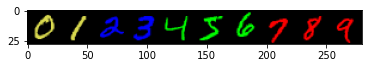

In [26]:
dataloader = ColorMNIST('num', 'train', path_to_mnist, randomcolor=False)
dataloader2 = DataLoader(dataloader, batch_size=32)
testloader = ColorMNIST('num', 'test', path_to_mnist, randomcolor=False)
testloader2 = DataLoader(testloader, batch_size=32)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

plt.imshow(x_all)
plt.show()

In [35]:
for epoch in range(n_epochs):
    # prep model for training
    model.train()
    # creating list to calculate loss and accuracy
    loss_list=[]
    ac_list=[]
    
    # train the model
    for data,target in dataloader:
        data_size=data.size(0)
        data=data.view(data_size, -1)
        # forward pass: compute predicted outputs by passing inputs to the model
        output=model(data) 
        # calculate the loss
        loss=criterion(output, target)
        # clear the gradients of all optimized variables
        model.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # parameter update
        optimiser.step()
        # filling loss and accuracy list
        loss_list.append(loss.item())
        ac_list.append(target.eq(output.detach().argmax(dim=1).cpu()).float().mean())
    # calculate loss and accuracy
    train_loss.append(float(torch.tensor(loss_list).mean()) * 100)
    train_ac.append(float(torch.tensor(ac_list).mean()) * 100)
    print('Epoch: ', epoch+1, '   ','Training loss: ',torch.tensor(loss_list).mean(), '   ','Training accuracy: ',torch.tensor(ac_list).mean())
    
    # initialize lists to monitor test loss and accuracy
    loss_list=[]
    ac_list=[]
    # *evaluation*
    model.eval()

    for data,target in testloader:
        data_size=data.size(0)
        data=data.view(data_size, -1)
        # no grad
        with torch.no_grad():
            output=model(data)
        # calculate the loss
        loss=criterion(output, target) 
        # filling loss and accuracy list
        loss_list.append(loss.item())
        ac_list.append(target.eq(output.detach().argmax(dim=1).cpu()).float().mean())
      
  # calculate loss and accuracy   
    test_loss.append(float(torch.tensor(loss_list).mean()) * 100)
    test_ac.append(float(torch.tensor(ac_list).mean()) * 100)
    print('Epoch: ', epoch+1, '   ','Training loss: ',torch.tensor(loss_list).mean(), '   ','Training accuracy: ',torch.tensor(ac_list).mean())
    
  

ValueError: Expected input batch_size (3) to match target batch_size (0).

In [ ]:
x_axis = range(0,5)
plt.plot(x_axis, train_loss, 'g', label='Training')
plt.plot(x_axis, test_loss, data_size, label='Validation')
plt.xlabel('Epoch number')
plt.ylabel('Loss rate')
plt.title('Graph of Losses')
plt.legend()
plt.show()


In [ ]:
plt.plot(x_axis, train_ac, 'g', label='Training')
plt.plot(x_axis, test_ac, data_size, label='Validation')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy rate')
plt.title('Graph of Accuracy')
plt.legend()
plt.show()